In [1]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:


corpus = []
with open('ER-Data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        corpus.append(row[1])
    
print(f"There are {len(corpus)} lines of dialogue\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])    

There are 8014 lines of dialogue

The first 5 lines look like this:

text
The Tarnished will soon return.
Guided by Grace once lost.
The Golden Order is broken to its core.
They will fight. And they will die. In an unending curse.


In [3]:
# Fit the tokenizer on the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [4]:
# Generate n-grams on the data
input_sequences = []
for line in corpus:
    sequence = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(sequence)):
        n_gram_sequence = sequence[:i+1]
        input_sequences.append(n_gram_sequence)

# Save max sequence length
max_sequence_len = max([len(x) for x in input_sequences])
        
print(f"There are {len(input_sequences)} n-grams\n")
print(f"The longest n-gram has {max_sequence_len} words\n")
print(f"The first 10 n-grams look like this:\n")
for i in range(10):
  print(input_sequences[i])        

There are 54010 n-grams

The longest n-gram has 30 words

The first 10 n-grams look like this:

[1, 40]
[1, 40, 22]
[1, 40, 22, 238]
[1, 40, 22, 238, 239]
[775, 36]
[775, 36, 114]
[775, 36, 114, 83]
[775, 36, 114, 83, 328]
[1, 131]
[1, 131, 121]


In [5]:
# pad sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
print(f"Padded corpus has shape {input_sequences.shape}\n")
print(f"The first 10 padded n-grams look like this:\n")
for i in range(10):
  print(input_sequences[i])


Padded corpus has shape (54010, 30)

The first 10 padded n-grams look like this:

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1 40]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1 40 22]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   1  40  22 238]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   1  40  22 238 239]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0 775  36]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 775  36 114]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 775  36 114  83]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 775  36 114  83

In [6]:
# Split the n-grams into feutures and labels
# The last word in each n-gram is the label
feutures, labels = input_sequences[:,:-1],input_sequences[:,-1]

# One-hot encode the labels
labels = to_categorical(labels, num_classes=total_words)

print(f"Feutures have shape {feutures.shape}\n")
print(f"Labels have shape {labels.shape}\n")
print(f"The first 5 feutures look like this:\n")
for i in range(5):
  print(feutures[i])
print(f"The first 5 labels look like this:\n")
for i in range(5):
  print(labels[i])

Feutures have shape (54010, 29)

Labels have shape (54010, 5195)

The first 5 feutures look like this:

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1 40]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  1 40 22]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   1  40  22 238]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0 775]
The first 5 labels look like this:

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [7]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words, 100, input_length=max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu')),
    tf.keras.layers.Dense(total_words, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
history = model.fit(feutures, labels, epochs=50, verbose=1)

Epoch 1/50


1688/1688 [==============================] - 35s 19ms/step - loss: 6.5192 - accuracy: 0.0588
Epoch 2/50
1688/1688 [==============================] - 32s 19ms/step - loss: 5.9045 - accuracy: 0.0894
Epoch 3/50
1688/1688 [==============================] - 31s 18ms/step - loss: 5.5228 - accuracy: 0.1185
Epoch 4/50
1688/1688 [==============================] - 31s 18ms/step - loss: 5.2055 - accuracy: 0.1424
Epoch 5/50
1688/1688 [==============================] - 36s 21ms/step - loss: 4.9106 - accuracy: 0.1612
Epoch 6/50
1688/1688 [==============================] - 32s 19ms/step - loss: 4.6245 - accuracy: 0.1815
Epoch 7/50
1688/1688 [==============================] - 34s 20ms/step - loss: 4.3365 - accuracy: 0.2016
Epoch 8/50
1688/1688 [==============================] - 32s 19ms/step - loss: 4.0469 - accuracy: 0.2300
Epoch 9/50
1688/1688 [==============================] - 35s 21ms/step - loss: 3.7510 - accuracy: 0.2590
Epoch 10/50
1688/1688 [==============================] - 37s 2

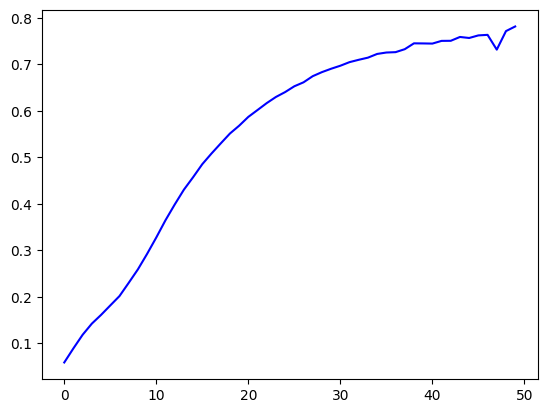

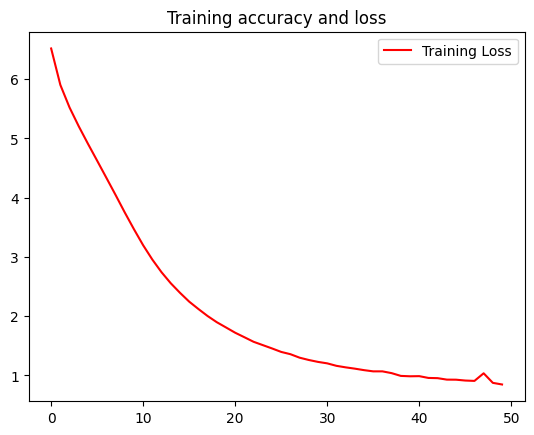

In [9]:
# plot the accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training accuracy and loss')
plt.legend()
plt.show()

In [10]:
# Saving the model and tokenizer
history.model.save('model', save_format='tf')
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
